In [54]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn import tree,ensemble
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve, f1_score
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns

# Predicting Bank Customers Churn
By: Ni Putu Intan Maharani (23522048)

## 1. Data Preparation and Feature Engineering
In this step:
1. Import the dataset
2. Identify missing values
3. Data type checking - for transformation
4. Splitting datasets to X (independent variables) and y (dependent variables)
4. Imbalance data analysis - including removing data with missing values

### 1.1. Import the dataset

In [2]:
src_folder = "/Users/intanmaharani/Desktop/Semester I August 2022/IF5171 - Pembelajaran Mesin DSAI/Prac3"
df_train_path = os.path.join(src_folder,"churn_train.csv")
df_test_path = os.path.join(src_folder,"churn_test.csv")

df_train = pd.read_csv(df_train_path)
df_test = pd.read_csv(df_test_path)

In [3]:
df_train.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x116,x117,x118,x119,x120,x121,x122,x123,x124,y
0,0.067563,-2.172492,-1.713774,-0.146854,-0.685219,-0.933838,4.0,2.0,-4.476051,-1.472306,...,4.607926,52.0,1.0,0.773809,0.766531,6.307142,9.074515,-2.694049,0.330964,0
1,0.099622,0.584803,-6.089758,-0.252186,-0.334912,-4.671281,4.0,2.0,-0.387076,-0.664552,...,15.889763,53.0,1.0,7.065852,0.994304,-0.028411,-21.472850,5.626095,1.293455,0
2,0.648421,3.881137,0.961359,0.217361,-1.471850,-0.975352,5.0,1.0,-0.850146,-4.011487,...,13.770410,53.0,1.0,-8.598553,-2.958302,-12.784030,-36.855873,0.356093,1.499790,0
3,0.005775,-2.726153,2.891378,-0.038325,2.280847,1.761478,3.0,3.0,9.116188,-4.610151,...,5.904901,50.0,1.0,8.194975,-7.798308,10.910515,15.226094,-10.440813,-0.735116,0
4,0.044396,2.803576,-1.923381,-0.116657,-1.574199,6.098627,3.0,1.0,-13.956141,13.785099,...,-14.603703,47.0,0.0,2.330789,-8.249825,-12.680490,40.192302,-5.037065,1.679262,1


In [4]:
df_test.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x116,x117,x118,x119,x120,x121,x122,x123,x124,y
0,0.403735,-1.966104,-1.322339,0.084642,2.481997,-1.719155,5.0,2.0,-11.546670,-7.073770,...,-7.765934,59.0,1.0,-9.897690,5.694125,-6.734618,17.052251,3.601040,2.873498,0
1,0.032128,6.516294,-0.939752,0.026937,-0.992999,5.995462,4.0,3.0,-5.634876,1.937998,...,15.667015,47.0,1.0,7.781887,9.752716,5.918369,15.922908,5.460557,10.475816,0
2,-0.280345,0.930291,-1.028828,-0.050924,-3.164733,6.885108,3.0,2.0,1.609005,-1.812488,...,8.523648,55.0,0.0,6.815214,-3.325532,4.123546,-19.656038,8.380318,-1.203315,0
3,-0.313420,-0.568857,-1.576051,-0.003607,5.539969,-1.594770,4.0,3.0,-11.517734,-5.364282,...,-13.912115,41.0,0.0,3.158137,-7.088875,-3.035983,34.277048,-3.169203,1.417681,0
4,0.108825,-4.815631,5.491084,-0.123928,-1.932024,4.014821,5.0,3.0,-3.117576,2.004889,...,-14.432712,52.0,0.0,-3.867657,-13.308519,1.008302,41.449381,-0.804560,-0.649453,0


In [5]:
df_train.shape

(100000, 126)

There are 100,000 rows of data with 126 attributes (125 independent variables and 1 dependent variable)

### 1.2. Identify missing values

In [7]:
df_train.isnull().sum()

x0      123
x1      131
x2      124
x3      115
x4      137
       ... 
x121    129
x122    127
x123    130
x124    123
y         0
Length: 126, dtype: int64

There are quite a larga number of missing values for each independent variables. In this case, DT/ensemble algorithms can handle missing values.

### 1.3. Data type checking and transformation

In [9]:
df_train.dtypes

x0      float64
x1      float64
x2      float64
x3      float64
x4      float64
         ...   
x121    float64
x122    float64
x123    float64
x124    float64
y         int64
Length: 126, dtype: object

In [16]:
features_to_encode = list(df_train.select_dtypes(include = ['object']).columns)
features_to_encode

['x21', 'x79', 'x89', 'x108', 'x112']

Independent variable x21, x79, x89, x108, x112 have the type of object. Therefore we need to transform this to numerical representation.

In [17]:
# x21
x21_unique = df_train['x21'].unique()
x21_d = {}
for idx,val in enumerate(x21_unique):
    x21_d[val]=idx
df_train['x21'] = df_train['x21'].map(x21_d)
df_test['x21'] = df_test['x21'].map(x21_d)

In [23]:
df_train['x21'].head()

0    0
1    1
2    1
3    0
4    1
Name: x21, dtype: int64

In [18]:
df_test['x21'].head()

0    1
1    1
2    0
3    5
4    8
Name: x21, dtype: int64

In [19]:
# x79
x79_unique = df_train['x79'].unique()
x79_d = {}
for idx,val in enumerate(x79_unique):
    x79_d[val]=idx
df_train['x79'] = df_train['x79'].map(x79_d)
df_test['x79'] = df_test['x79'].map(x79_d)

In [24]:
df_train['x79'].head()

0    0
1    1
2    1
3    0
4    0
Name: x79, dtype: int64

In [20]:
df_test['x79'].head()

0    0
1    0
2    0
3    1
4    1
Name: x79, dtype: int64

In [21]:
# x89
x89_unique = df_train['x89'].unique()
x89_d = {}
for idx,val in enumerate(x89_unique):
    x89_d[val]=idx
df_train['x89'] = df_train['x89'].map(x89_d)
df_test['x89'] = df_test['x89'].map(x89_d)

In [25]:
df_train['x89'].head()

0    0
1    1
2    2
3    3
4    3
Name: x89, dtype: int64

In [26]:
df_test['x89'].head()

0     7
1     8
2     7
3     0
4    11
Name: x89, dtype: int64

In [27]:
# x108
x108_unique = df_train['x108'].unique()
x108_d = {}
for idx,val in enumerate(x108_unique):
    x108_d[val]=idx
df_train['x108'] = df_train['x108'].map(x108_d)
df_test['x108'] = df_test['x108'].map(x108_d)

In [28]:
df_train['x108'].head()

0    0
1    0
2    1
3    0
4    2
Name: x108, dtype: int64

In [29]:
df_test['x108'].head()

0    0
1    0
2    0
3    0
4    0
Name: x108, dtype: int64

In [30]:
# x112
x112_unique = df_train['x112'].unique()
x112_d = {}
for idx,val in enumerate(x112_unique):
    x112_d[val]=idx
df_train['x112'] = df_train['x112'].map(x112_d)
df_test['x112'] = df_test['x112'].map(x112_d)

In [31]:
df_train['x112'].head()

0    0
1    0
2    1
3    2
4    1
Name: x112, dtype: int64

In [32]:
df_test['x112'].head()

0    4
1    2
2    4
3    1
4    0
Name: x112, dtype: int64

### 1.4. Splitting datasets to X (independent variables) and y (dependent variable)

In [33]:
attributes = list(df_train.columns)
features = attributes[:-1]
target = attributes[-1:]
print(f">>List of features: {features}\n>>Target: {target}")

>>List of features: ['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19', 'x20', 'x21', 'x22', 'x23', 'x24', 'x25', 'x26', 'x27', 'x28', 'x29', 'x30', 'x31', 'x32', 'x33', 'x34', 'x35', 'x36', 'x37', 'x38', 'x39', 'x40', 'x41', 'x42', 'x43', 'x44', 'x45', 'x46', 'x47', 'x48', 'x49', 'x50', 'x51', 'x52', 'x53', 'x54', 'x55', 'x56', 'x57', 'x58', 'x59', 'x60', 'x61', 'x62', 'x63', 'x64', 'x65', 'x66', 'x67', 'x68', 'x69', 'x70', 'x71', 'x72', 'x73', 'x74', 'x75', 'x76', 'x77', 'x78', 'x79', 'x80', 'x81', 'x82', 'x83', 'x84', 'x85', 'x86', 'x87', 'x88', 'x89', 'x90', 'x91', 'x92', 'x93', 'x94', 'x95', 'x96', 'x97', 'x98', 'x99', 'x100', 'x101', 'x102', 'x103', 'x104', 'x105', 'x106', 'x107', 'x108', 'x109', 'x110', 'x111', 'x112', 'x113', 'x114', 'x115', 'x116', 'x117', 'x118', 'x119', 'x120', 'x121', 'x122', 'x123', 'x124']
>>Target: ['y']


In [34]:
# Splitting the datasets
X_train = df_train[features].values
y_train = df_train[target].values.flatten()
X_test = df_test[features].values
y_test = df_test[target].values.flatten()

### 1.5. Imbalance data analysis

In [35]:
from collections import Counter
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler

Class=0, n=83008 (83.00800000000001%)
Class=1, n=16992 (16.991999999999997%)


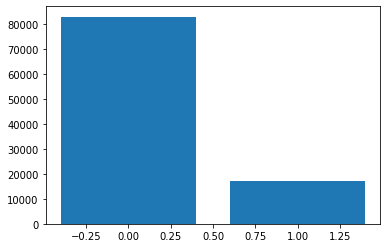

In [36]:
counter = Counter(y_train)
plt.bar(counter.keys(), counter.values())
for k, v in counter.items():
    dist = v/len(y_train) * 100
    print(f"Class={k}, n={v} ({dist}%)")

It can be seen that ~83% of the data is in class 0 and the remaining is in class 1. Therefore, sampling techniques will be performed to balance the data for each class. Oversampling will be used in this case (i.e., SMOTE and ADASYN) as well as Undersampling (i.e., RandomUnderSampler)

#### 1.5.1. SMOTE Oversampling

In [38]:
smote = SMOTE()
# Drop NaN values
df_train_nan_dropped = df_train[:].dropna()
X_train_nan_dropped = df_train_nan_dropped[features].values
y_train_nan_dropped = df_train_nan_dropped[target].values.flatten()
X_train_smote, y_train_smote = smote.fit_resample(X_train_nan_dropped, y_train_nan_dropped)

Class=0, n=70237 (50.0%)
Class=1, n=70237 (50.0%)


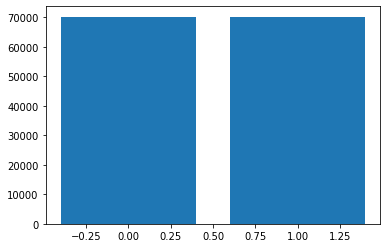

In [40]:
counter = Counter(y_train_smote)
plt.bar(counter.keys(), counter.values())
for k, v in counter.items():
    dist = v/len(y_train_smote) * 100
    print(f"Class={k}, n={v} ({dist}%)")

#### 1.5.2. ADASYN Oversampling

Class=0, n=70237 (50.90707467511288%)
Class=1, n=67734 (49.09292532488712%)


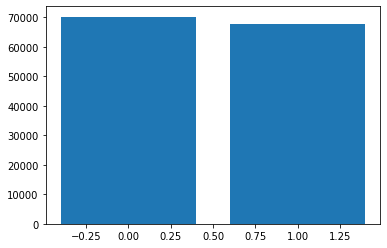

In [41]:
adasyn = ADASYN()
X_train_ada, y_train_ada = adasyn.fit_resample(X_train_nan_dropped, y_train_nan_dropped)

# Check how 'balanced' the dataset - target class - is after oversampling
counter = Counter(y_train_ada)
plt.bar(counter.keys(), counter.values())
for k, v in counter.items():
    dist = v/len(y_train_ada) * 100
    print(f"Class={k}, n={v} ({dist}%)")

#### 1.5.3. RandomUnderSampler Undersampling

Class=0, n=14388 (50.0%)
Class=1, n=14388 (50.0%)


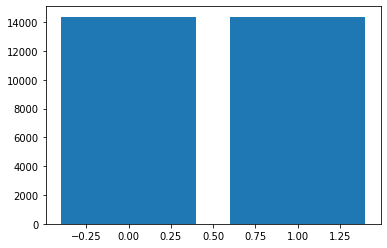

In [42]:
rus = RandomUnderSampler()
X_train_rus, y_train_rus = rus.fit_resample(X_train_nan_dropped, y_train_nan_dropped)

# Check how 'balanced' the dataset - target class - is after oversampling
counter = Counter(y_train_rus)
plt.bar(counter.keys(), counter.values())
for k, v in counter.items():
    dist = v/len(y_train_rus) * 100
    print(f"Class={k}, n={v} ({dist}%)")

We will perform experiments in training by using:
1. the imbalanced dataset => X_train, y_train
2. the oversampled dataset (SMOTE) => X_train_smote, y_train_smote
3. the oversampled dataset (ADASYN) => X_train_ada, y_train_ada
4. the undersampled dataset (RandomUnderSampler) => X_train_rus, y_train_rus

PS: For sampled dataset, df_test containing NaN values will be dropped

In [49]:
df_test_nan_dropped = df_test[:].dropna()
X_test_nan_dropped = df_test_nan_dropped[features].values
y_test_nan_dropped = df_test_nan_dropped[target].values.flatten()

In [50]:
df_test_nan_dropped.shape

(21060, 126)

## 2. Exploratory Data Analysis

In [46]:
# Get the summary statistics of the given dataset
df_train.describe()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x116,x117,x118,x119,x120,x121,x122,x123,x124,y
count,99877.000000,99869.000000,99876.000000,99885.000000,99863.000000,99884.000000,99878.000000,99867.000000,99866.000000,99870.000000,...,99877.000000,99864.000000,99873.000000,99878.000000,99880.000000,99871.000000,99873.000000,99870.000000,99877.000000,100000.000000
mean,-0.000110,0.001045,0.009028,-0.000254,-0.677076,-0.002404,4.306714,2.366517,0.013684,-0.016469,...,0.038825,50.012697,0.577373,3.883003,-0.021634,-0.015191,7.594731,-0.012175,0.008854,0.169920
std,0.424300,3.379969,3.088269,0.121542,2.561589,4.042530,1.140149,0.728027,7.766165,5.391990,...,9.063181,6.892136,0.493980,10.795317,5.571357,9.745984,35.358657,3.947540,4.128462,0.375564
min,-1.724571,-16.097070,-13.519334,-0.517647,-13.627396,-16.984482,0.000000,0.000000,-34.513401,-23.449782,...,-37.320446,21.000000,0.000000,-42.113882,-23.512064,-43.961674,-165.068134,-17.229400,-16.394975,0.000000
25%,-0.288149,-2.274297,-2.070010,-0.082583,-2.384499,-2.732918,4.000000,2.000000,-5.233073,-3.642062,...,-6.077436,45.000000,0.000000,-3.247750,-3.776839,-6.630953,-16.275026,-2.656104,-2.766022,0.000000
50%,-0.000976,0.015052,0.014444,-0.000445,-0.679873,0.000063,4.000000,2.000000,0.004569,-0.034581,...,0.044680,50.000000,1.000000,3.900552,-0.018491,-0.025400,6.668708,-0.032674,-0.002028,0.000000
75%,0.286196,2.288710,2.087186,0.081461,1.034269,2.726788,5.000000,3.000000,5.273118,3.617453,...,6.144167,54.000000,1.000000,11.039607,3.743165,6.594418,30.879552,2.638333,2.788782,0.000000
max,1.762542,14.768077,13.335437,0.513763,10.442234,20.186745,9.000000,5.000000,33.000825,23.296840,...,38.712294,80.000000,1.000000,57.003256,25.927916,41.261627,174.645087,17.058603,17.921770,1.000000


In [47]:
# Get the summary statistics of the given dataset (NaN dropped)
df_train_nan_dropped.describe()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x116,x117,x118,x119,x120,x121,x122,x123,x124,y
count,84625.000000,84625.000000,84625.000000,84625.000000,84625.000000,84625.000000,84625.000000,84625.000000,84625.000000,84625.000000,...,84625.000000,84625.000000,84625.000000,84625.000000,84625.000000,84625.000000,84625.000000,84625.000000,84625.000000,84625.000000
mean,0.000134,-0.005367,0.012730,-0.000499,-0.679438,-0.000102,4.305855,2.367244,0.016531,-0.020500,...,0.051632,50.008815,0.577229,3.884232,-0.026894,0.008140,7.594259,-0.008721,0.006708,0.170021
std,0.424150,3.382031,3.089167,0.121762,2.562778,4.037325,1.139768,0.728401,7.777533,5.385425,...,9.064099,6.903307,0.494003,10.809025,5.576218,9.743352,35.432185,3.955279,4.132098,0.375653
min,-1.724571,-16.097070,-13.519334,-0.517647,-13.627396,-16.984482,0.000000,0.000000,-34.513401,-21.393586,...,-37.320446,22.000000,0.000000,-42.113882,-23.512064,-42.803538,-165.068134,-17.229400,-16.394975,0.000000
25%,-0.288439,-2.277408,-2.066637,-0.083161,-2.384102,-2.719394,4.000000,2.000000,-5.231273,-3.653562,...,-6.056929,45.000000,0.000000,-3.242579,-3.794949,-6.618319,-16.313432,-2.657868,-2.770613,0.000000
50%,-0.000575,0.015830,0.022342,-0.000690,-0.683342,0.008073,4.000000,2.000000,0.008370,-0.043343,...,0.046831,50.000000,1.000000,3.898811,-0.024713,-0.014172,6.669958,-0.028475,-0.008476,0.000000
75%,0.286555,2.282198,2.097138,0.081502,1.033504,2.719203,5.000000,3.000000,5.285481,3.603270,...,6.160476,54.000000,1.000000,11.038551,3.745235,6.652677,30.897783,2.646747,2.788143,0.000000
max,1.714387,14.768077,13.335437,0.513763,10.442234,20.186745,9.000000,5.000000,31.449940,23.296840,...,38.141106,80.000000,1.000000,57.003256,25.927916,41.261627,174.645087,17.058603,17.921770,1.000000


It can be seen the data with dropped nan values is reduced from 100,000 rows to 84,625 rows.

### 2.1. Correlation Coefficient

In [52]:
# NaN values not dropped
df_train_corr = df_train.corr()

In [56]:
df_train_corr

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x116,x117,x118,x119,x120,x121,x122,x123,x124,y
x0,1.000000,-0.000851,-0.001769,-0.003981,0.004158,-0.002562,-0.002733,0.002988,-0.000337,0.005547,...,-0.002329,-0.001543,-0.001810,-0.000421,0.001778,0.000240,0.002149,0.003763,0.002547,-0.001644
x1,-0.000851,1.000000,-0.005267,0.000171,-0.001632,0.003393,0.003063,0.005959,-0.006401,-0.003348,...,0.000925,-0.001786,-0.002230,-0.000263,-0.000645,-0.006180,0.002637,-0.003784,0.001868,-0.002780
x2,-0.001769,-0.005267,1.000000,0.001796,-0.001360,0.000311,-0.002994,0.000408,0.004945,-0.000670,...,-0.000236,0.002983,-0.002159,-0.003031,-0.002310,-0.003096,0.003399,-0.002596,-0.001971,-0.000664
x3,-0.003981,0.000171,0.001796,1.000000,-0.000927,0.001838,-0.002631,0.001262,0.000837,0.003774,...,0.001051,0.001175,-0.003233,-0.002328,-0.002479,0.000531,0.002679,-0.003049,-0.003161,0.001639
x4,0.004158,-0.001632,-0.001360,-0.000927,1.000000,0.003981,-0.002251,-0.001737,0.002565,-0.001022,...,0.002183,-0.191762,0.280648,-0.155789,0.002526,0.001988,-0.019127,-0.001366,-0.004206,0.007267
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
x121,0.000240,-0.006180,-0.003096,0.000531,0.001988,-0.005344,-0.001901,-0.000597,-0.002660,-0.002376,...,-0.000291,0.003752,0.003308,0.000178,0.001130,1.000000,-0.004481,0.000072,-0.005440,-0.001313
x122,0.002149,0.002637,0.003399,0.002679,-0.019127,-0.003970,0.005172,0.000299,-0.002291,0.003621,...,0.002412,-0.607116,-0.059400,0.372855,-0.004688,-0.004481,1.000000,-0.007807,-0.003068,-0.041442
x123,0.003763,-0.003784,-0.002596,-0.003049,-0.001366,0.001125,0.000313,0.003072,-0.000046,0.001827,...,-0.007059,0.005614,0.002366,-0.001437,0.002980,0.000072,-0.007807,1.000000,0.004455,-0.000666
x124,0.002547,0.001868,-0.001971,-0.003161,-0.004206,-0.000228,0.002808,-0.003338,0.004651,0.001572,...,0.003675,0.004731,0.000946,0.001266,-0.000587,-0.005440,-0.003068,0.004455,1.000000,-0.002676


In [57]:
type(df_train_corr)

pandas.core.frame.DataFrame

In [59]:
df_train_corr_to_y = df_train_corr['y']
# type(df_train_corr_to_y)

pandas.core.series.Series

#### 2.1.1 Get variables with strong correlation with target variable y (strong positive and strong negative)

Strong negative correlation

In [64]:
df_train_corr_to_y_asc = df_train_corr_to_y.sort_values(ascending=True)
df_train_corr_to_y_asc.head(20)

x57    -0.128242
x41    -0.120998
x60    -0.113804
x44    -0.097781
x105   -0.094995
x67    -0.083999
x119   -0.080113
x61    -0.075836
x13    -0.072913
x62    -0.069361
x59    -0.064507
x72    -0.057125
x122   -0.041442
x107   -0.026857
x19    -0.020853
x82    -0.017467
x29    -0.010689
x12    -0.009049
x32    -0.006683
x9     -0.006534
Name: y, dtype: float64

In [83]:
strong_negative = ['x57','x41','x60','x44','x105','x67','x119','x61','x13','x62','x59','x72','x122','x107','x19','x82','x29']

Strong positive correlation

In [84]:
df_train_corr_to_y_dsc = df_train_corr_to_y.sort_values(ascending=False)
df_train_corr_to_y_dsc.head(24)

y       1.000000
x17     0.136983
x106    0.113577
x92     0.085921
x91     0.078085
x28     0.068710
x46     0.067976
x118    0.067032
x96     0.065964
x104    0.061336
x117    0.052421
x65     0.051633
x75     0.043178
x45     0.043160
x35     0.041194
x103    0.039896
x39     0.033654
x15     0.030245
x50     0.012614
x71     0.011542
x73     0.010830
x31     0.010344
x64     0.007614
x4      0.007267
Name: y, dtype: float64

In [91]:
strong_positive = ['x17','x106','x92','x91','x28','x46','x118','x96','x104','x117','x65','x75','x45','x35','x103','x39','x15','x50','x71','x73','x31']

Later in this notebook, during model building, using only independent variables with strong positive and negative correlation will be included in the experiment.

## 3. Modeling
The ML algorithm that will be used in this case is XGBoost.

<p><strong>XGBoost - Extreme Gradient Boosting</strong></p>
XGBoost is the optimized version of Gradient Boosting algorithm through parallel processing (i.e., tree building) and tree pruning using depth-first approach. XGBoost is also able to handle missing values and regularization in order to avoid overfitting/bias. It also has an in-built cross-validation capability.

List of experiments:

1. Without resampling and with tuning
2. SMOTE oversampled (use test set with dropped nan values)
3. ADASYN oversampled (use test set with dropped nan values)
4. RandomUnderSampler undersampled (use test set with dropped nan values)
5. Dropped features with correlation coefficient >-0.01 and <0.01, without resampling

Then, to the best model in terms of accuracy, hyperparameter tuning will be performed to find the best combination of parameters.

### 3.1. Without resampling

In [74]:
from xgboost import XGBClassifier

In [75]:
# fit model no training data
xgb_1 = XGBClassifier()
xgb_1.fit(X_train, y_train)

# Prediction
y_pred_1 = xgb_1.predict(X_test)

# Evaluation - accuracy
accuracy_1 = accuracy_score(y_test,y_pred_1)
print(f"The accuracy of the model is {round(accuracy_1,3)*100}%")

The accuracy of the model is 88.6%


### 3.2. SMOTE oversampled

In [76]:
xgb_smote = XGBClassifier()
xgb_smote.fit(X_train_smote, y_train_smote)

# Prediction
y_pred_smote = xgb_smote.predict(X_test_nan_dropped)

# Evaluation - accuracy
accuracy_smote = accuracy_score(y_test_nan_dropped,y_pred_smote)
print(f"The accuracy of the model is {round(accuracy_smote,3)*100}%")

The accuracy of the model is 88.2%


### 3.3. ADASYN oversampled

In [77]:
xgb_ada = XGBClassifier(random_state=0)
xgb_ada.fit(X_train_ada, y_train_ada)

# Prediction
y_pred_ada = xgb_smote.predict(X_test_nan_dropped)

# Evaluation - accuracy
accuracy_ada = accuracy_score(y_test_nan_dropped,y_pred_ada)
print(f"The accuracy of the model is {round(accuracy_ada,3)*100}%")

The accuracy of the model is 88.2%


### 3.4. RandomUnderSampler undersampled

In [78]:
xgb_rus = XGBClassifier(random_state=0)
xgb_rus.fit(X_train_rus, y_train_rus)

# Prediction
y_pred_rus = xgb_rus.predict(X_test_nan_dropped)

# Evaluation - accuracy
accuracy_rus = accuracy_score(y_test_nan_dropped,y_pred_rus)
print(f"The accuracy of the model is {round(accuracy_rus,3)*100}%")

The accuracy of the model is 76.0%


### 3.5. Dropped features with weak correlations

In [92]:
# Attributes with strong negative correlations to y
strong_negative

['x57',
 'x41',
 'x60',
 'x44',
 'x105',
 'x67',
 'x119',
 'x61',
 'x13',
 'x62',
 'x59',
 'x72',
 'x122',
 'x107',
 'x19',
 'x82',
 'x29']

In [93]:
# Attributes with strong positive correlations to y
strong_positive

['x17',
 'x106',
 'x92',
 'x91',
 'x28',
 'x46',
 'x118',
 'x96',
 'x104',
 'x117',
 'x65',
 'x75',
 'x45',
 'x35',
 'x103',
 'x39',
 'x15',
 'x50',
 'x71',
 'x73',
 'x31']

In [100]:
strong_correlations = strong_negative+strong_positive
strong_correlations.append('y')
strong_correlations

['x57',
 'x41',
 'x60',
 'x44',
 'x105',
 'x67',
 'x119',
 'x61',
 'x13',
 'x62',
 'x59',
 'x72',
 'x122',
 'x107',
 'x19',
 'x82',
 'x29',
 'x17',
 'x106',
 'x92',
 'x91',
 'x28',
 'x46',
 'x118',
 'x96',
 'x104',
 'x117',
 'x65',
 'x75',
 'x45',
 'x35',
 'x103',
 'x39',
 'x15',
 'x50',
 'x71',
 'x73',
 'x31',
 'y']

In [101]:
# Create a copy dataset with only the above attributes
df_train_sc = df_train[:]
df_train_sc = df_train_sc[strong_correlations]
df_test_sc = df_test[:]
df_test_sc = df_test_sc[strong_correlations]

In [102]:
df_train_sc.head()

,x57,x41,x60,x44,x105,x67,x119,x61,x13,x62,...,x45,x35,x103,x39,x15,x50,x71,x73,x31,y
0,-0.395665,21.860965,-23.431641,16.179453,36.329967,-58.953416,0.773809,13.751744,-8.340786,-26.500714,...,39.545280,11.068075,0.514885,-7.450657,-19.878081,-55.922397,19.563718,32.209681,-27.698764,0
1,-0.362896,18.327611,1.183948,-34.864322,-13.448378,74.633579,7.065852,-9.282450,-5.618335,19.474037,...,-4.474592,-13.186784,-1.845015,-0.962187,3.481345,46.166641,-10.319307,21.524979,7.889010,0
2,-1.473236,6.898550,-2.325219,24.095527,-25.670791,52.444828,-8.598553,-7.472724,-3.618850,19.527319,...,-6.703214,-10.201114,-0.850936,-17.172271,3.771034,27.729470,-14.488131,-6.662494,11.004250,0
3,5.478409,14.613527,6.255019,-50.442312,4.057570,7.447102,8.194975,12.480775,-2.399277,-25.743925,...,11.822118,3.699499,-1.124832,7.610184,-0.142621,-1.268939,37.358118,58.099294,-33.151758,0
4,5.247766,-16.016833,1.628471,47.675250,45.817767,-26.552274,2.330789,11.202072,-1.973822,-2.409916,...,4.629616,8.813286,-0.404615,5.343754,-1.235130,14.594703,23.074105,47.049903,-12.489286,1


In [103]:
df_test_sc.head(10)

,x57,x41,x60,x44,x105,x67,x119,x61,x13,x62,...,x45,x35,x103,x39,x15,x50,x71,x73,x31,y
0,0.259909,13.055414,-14.315786,-38.643101,25.630266,58.568901,-9.897690,-14.132548,4.959509,48.656974,...,-51.054889,0.044943,-4.374817,16.140605,-2.030356,70.957171,6.621634,4.653935,44.933636,0
1,-4.918258,-3.085948,0.160628,-12.443104,42.942199,-7.136370,7.781887,-0.786236,-2.020895,12.591929,...,22.933258,-1.752173,0.252021,9.891922,-9.165506,-6.377254,-23.748115,-0.305002,24.533511,0
2,4.480739,-5.210111,20.649833,31.204872,-1.026669,38.793240,6.815214,-1.297034,6.498108,4.741591,...,-8.547329,-0.216140,-2.128526,-20.987141,9.434490,2.802802,-24.668008,21.679257,-7.476300,0
3,10.065273,60.515760,55.892023,-2.648475,85.185923,40.321194,3.158137,31.886691,12.038212,17.060105,...,22.486305,3.462986,3.969886,-9.520847,-12.081526,-1.136188,-21.293066,14.382409,26.038436,0
4,2.221712,-49.429186,-23.720409,35.199209,-2.742862,-52.903473,-3.867657,5.032388,5.525227,-8.704657,...,-38.270309,13.566662,2.115363,20.445398,-0.723274,64.575428,54.881302,2.176974,1.656484,0
5,-1.573296,-54.207520,-13.298627,61.153183,40.806962,-16.649762,2.512500,-8.352572,4.375033,56.577148,...,-38.722231,8.095999,-2.589531,19.825293,2.514180,96.374311,-52.646575,-19.855371,37.152902,1
6,1.264067,-31.415760,-14.204266,-38.582393,2.053739,0.839982,-6.453662,-11.628646,-2.122468,-23.850243,...,-14.885580,7.759992,2.211927,0.417666,2.695669,24.008443,63.401788,55.775852,20.444293,1
7,-6.163186,9.041720,-12.258371,-37.583716,-58.085827,47.075475,6.235511,-10.868620,-8.394505,33.790714,...,0.943897,-17.215546,-2.334406,6.531753,3.381380,82.600231,-44.264648,-45.984839,-1.072960,0
8,-4.166338,-36.640211,1.752627,-25.495612,-21.559009,-55.832402,-2.424945,10.755499,1.507899,-23.464339,...,35.364796,3.089724,-0.898622,21.964271,4.042090,-28.975374,4.951003,11.122772,-27.483886,1
9,3.277016,38.108368,8.625983,25.744151,22.272007,40.094550,14.437596,-14.814127,2.851070,33.685441,...,-60.450034,-11.217944,-1.993447,11.398218,4.412487,2.972844,-3.222132,-60.719663,15.600088,0


In [106]:
# Splitting the resulted dataset to X and y
sc_features = strong_negative + strong_positive
X_train_sc = df_train_sc[sc_features].values
y_train_sc = df_train_sc['y'].values.flatten()
X_test_sc = df_test_sc[sc_features].values
y_test_sc = df_test_sc['y'].values.flatten()

In [110]:
# Model
xgb_sc = XGBClassifier(random_state=0)
xgb_sc.fit(X_train_sc, y_train_sc)

# Prediction
y_pred_sc = xgb_sc.predict(X_test_sc)

# Evaluation - accuracy
accuracy_sc = accuracy_score(y_test_sc,y_pred_sc)
print(f"The accuracy of the model is {round(accuracy_sc,3)*100}%")

The accuracy of the model is 88.8%


### 3.6. Dropped features with weak correlation to y and with hyperparameter tuning

#### 3.6.1 Intuitively

In [126]:
xgb_sc_tuned_1 = XGBClassifier(random_state=0,max_depth=5,n_estimators=100,learning_rate=0.3,subsample=0.6,gamma=0.8,reg_lambda=1.2,alpha=0.2)
xgb_sc_tuned_1.fit(X_train_sc, y_train_sc)

# Prediction
y_pred_sc_tuned_1 = xgb_sc_tuned_1.predict(X_test_sc)

# Evaluation - accuracy
accuracy_sc_tuned_1 = accuracy_score(y_test_sc,y_pred_sc_tuned_1)
print(f"The accuracy of the model is {round(accuracy_sc_tuned_1,3)*100}%")

The accuracy of the model is 88.6%


In [131]:
xgb_sc_tuned_2 = XGBClassifier(random_state=0,max_depth=5,n_estimators=500,learning_rate=0.3,subsample=0.6,gamma=0.8,reg_lambda=1.2,alpha=0.2)
xgb_sc_tuned_2.fit(X_train_sc, y_train_sc)

# Prediction
y_pred_sc_tuned_2 = xgb_sc_tuned_2.predict(X_test_sc)

# Evaluation - accuracy
accuracy_sc_tuned_2 = accuracy_score(y_test_sc,y_pred_sc_tuned_2)
print(f"The accuracy of the model is {round(accuracy_sc_tuned_2,3)*100}%")

The accuracy of the model is 88.8%


Class=0, n=20696 (82.784%)
Class=1, n=4304 (17.216%)


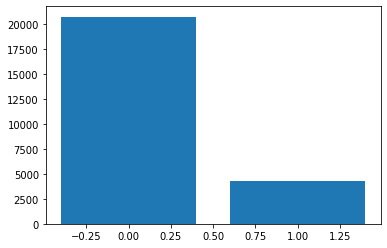

In [187]:
# Test data: Is it balance?
counter = Counter(y_test)
plt.bar(counter.keys(), counter.values())
for k, v in counter.items():
    dist = v/len(y_test) * 100
    print(f"Class={k}, n={v} ({dist}%)")

#### 3.6.2. GridSearch

In [118]:
from sklearn.model_selection import GridSearchCV

In [119]:
params = {
    'max_depth': [3,6,10], 
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 500, 1000],
    'colsample_bytree': [0.3, 0.7],
    'subsample':[0.5,1]}

xgb_estimator = XGBClassifier(random_state=0)
grid_search = GridSearchCV(estimator=xgb_estimator, 
                   param_grid=params,
                   scoring='accuracy', 
                   verbose=1)

grid_result = grid_search.fit(X_train_sc, y_train_sc)
print("Best parameters:", grid_result.best_params_)
print("Best Accuracy: ", (grid_result.best_score_))

Fitting 5 folds for each of 108 candidates, totalling 540 fits


KeyboardInterrupt: 

PS: if time allows, it will be better if a grid search is performed to find the best combination of parameters to be used in the XGBClassifier. Currently it is stopped because it already took hours to compile (more than 6 hours).

## 4. Evaluation and Remodel
Comparing each of the experimented model by its accuracy, precision, recall, False Positive Rates (FPR), AUC, and ROC

In [216]:
models = {
    'xgb_1': y_pred_1,
    'xgb_smote': y_pred_smote,
    'xgb_ada': y_pred_ada,
    'xgb_rus': y_pred_rus,
    'xgb_sc': y_pred_sc,
    'xgb_sc_tuned_1': y_pred_sc_tuned_1,
    'xgb_sc_tuned_2': y_pred_sc_tuned_2
}

for key, val in models.items():
    test = ''
    # Selecting test set
    if key == 'xgb_1':
        test = y_test
    elif key == 'xgb_sc' or key == 'xgb_sc_tuned_1' or key == 'xgb_sc_tuned_2':
        test = y_test_sc
    else:
        test = y_test_nan_dropped
        
    
    print(f"Model: {key}")
    accuracy = accuracy_score(test,val)
    print(f"The accuracy of the {key} model is {round(accuracy,3)*100}%")

    precision = precision_score(test,val)
    print(f"The precision of the {key} model is {round(precision,3)*100}%")

    recall = recall_score(test,val)
    print(f"The recall score of the {key} model is {round(recall,3)*100}%")

    f1 = f1_score(test,val)
    print(f"The f1 score of the {key} model is {round(f1,3)*100}%")
    
    print("==============================================================================")

Model: xgb_1
The accuracy of the xgb_1 model is 88.6%
The precision of the xgb_1 model is 87.7%
The recall score of the xgb_1 model is 39.1%
The f1 score of the xgb_1 model is 54.1%
Model: xgb_smote
The accuracy of the xgb_smote model is 88.2%
The precision of the xgb_smote model is 86.2%
The recall score of the xgb_smote model is 37.3%
The f1 score of the xgb_smote model is 52.1%
Model: xgb_ada
The accuracy of the xgb_ada model is 88.2%
The precision of the xgb_ada model is 86.2%
The recall score of the xgb_ada model is 37.3%
The f1 score of the xgb_ada model is 52.1%
Model: xgb_rus
The accuracy of the xgb_rus model is 76.0%
The precision of the xgb_rus model is 37.4%
The recall score of the xgb_rus model is 59.4%
The f1 score of the xgb_rus model is 45.9%
Model: xgb_sc
The accuracy of the xgb_sc model is 88.8%
The precision of the xgb_sc model is 88.5%
The recall score of the xgb_sc model is 39.800000000000004%
The f1 score of the xgb_sc model is 54.900000000000006%
Model: xgb_sc_tun

### 4.1. Remodel and get the feature importance for the developed model
From the evaluation above, it can be seen that xgb_sc model has the best f1 score of 54.9%, however, the training data was not resampled to make it balanced between each of the class (0 or 1). Therefore, in this section, an experiment to remodel with oversampled data train (i.e., using SMOTE) combined with dropping attributes with weak correlations to target variable y will be performed.

note: xgb_smote (SMOTE oversampled) and xgb_sc (dropped attr. with weak correlations without oversampling)

In [186]:
# Oversampled data with only strongly correlated attributes

df_train_nan_dropped_sc = df_train_nan_dropped[:]

X_train_nan_dropped_sc = df_train_nan_dropped_sc[sc_features].values
y_train_nan_dropped_sc = df_train_nan_dropped_sc[target].values.flatten()

X_train_smote_sc, y_train_smote_sc = smote.fit_resample(X_train_nan_dropped_sc, y_train_nan_dropped_sc)

# Test data: use the NaN dropped: X_test_nan_dropped and y_test_nan_dropped with sc?????

In [189]:
df_test_nan_dropped_sc = df_test_nan_dropped[:]
X_test_nan_dropped_sc = df_test_nan_dropped_sc[sc_features].values
y_test_nan_dropped_sc = df_test_nan_dropped_sc[target].values.flatten()

Class=0, n=70237 (50.0%)
Class=1, n=70237 (50.0%)


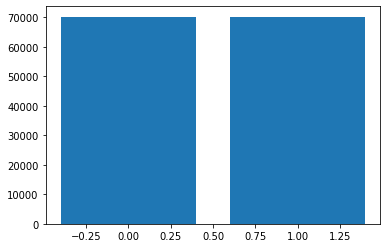

In [188]:
counter = Counter(y_train_smote_sc)
plt.bar(counter.keys(), counter.values())
for k, v in counter.items():
    dist = v/len(y_train_smote_sc) * 100
    print(f"Class={k}, n={v} ({dist}%)")

In [191]:
# Model
xgb_smote_sc = XGBClassifier(random_state=0)
xgb_smote_sc.fit(X_train_smote_sc, y_train_smote_sc)

# Prediction
y_pred_smote_sc = xgb_smote_sc.predict(X_test_nan_dropped_sc)

# Evaluation - accuracy
accuracy_smote_sc = accuracy_score(y_test_nan_dropped_sc,y_pred_smote_sc)
print(f"The accuracy of the model is {round(accuracy_smote_sc,3)*100}%")

precision_smote_sc = precision_score(y_test_nan_dropped_sc,y_pred_smote_sc)
print(f"The precision of the model is {round(precision_smote_sc,3)*100}%")

recall_smote_sc = recall_score(y_test_nan_dropped_sc,y_pred_smote_sc)
print(f"The recall of the model is {round(recall_smote_sc,3)*100}%")

f1_smote_sc = f1_score(y_test_nan_dropped_sc,y_pred_smote_sc)
print(f"The f1 of the model is {round(f1_smote_sc,3)*100}%")

The accuracy of the model is 88.9%
The precision of the model is 87.0%
The recall of the model is 41.199999999999996%
The f1 of the model is 55.900000000000006%


The model performs better than previous ones. Now, its feature importance will be explored and by using attributes with feature importance >= 0.005, the model will be redeveloped.

In [192]:
# Feature importance for model: xgb_smote_sc
fi_xgb_smote_sc = xgb_smote_sc.feature_importances_
relative_importance_fi_xgb_smote_sc = pd.DataFrame(index=sc_features, data=fi_xgb_smote_sc, columns=['importance'])
fi_xgb_smote_sc_selected = relative_importance_fi_xgb_smote_sc.index[relative_importance_fi_xgb_smote_sc['importance'] >= 0.005].tolist()
fi_xgb_smote_sc_selected

['x57',
 'x41',
 'x60',
 'x44',
 'x105',
 'x67',
 'x119',
 'x61',
 'x13',
 'x62',
 'x59',
 'x72',
 'x122',
 'x107',
 'x19',
 'x82',
 'x17',
 'x106',
 'x92',
 'x91',
 'x28',
 'x46',
 'x118',
 'x96',
 'x104',
 'x117',
 'x65',
 'x75',
 'x45',
 'x35',
 'x103',
 'x39',
 'x15',
 'x50',
 'x71',
 'x31']

In [193]:
# Redevelop the model with attributes that have feature importance of >= 0.005
X_train_nan_dropped_sc_fi = df_train_nan_dropped_sc[fi_xgb_smote_sc_selected].values
y_train_nan_dropped_sc_fi = df_train_nan_dropped_sc[target].values.flatten()

X_train_smote_sc_fi, y_train_smote_sc_fi = smote.fit_resample(X_train_nan_dropped_sc_fi, y_train_nan_dropped_sc_fi)

In [194]:
X_test_nan_dropped_sc_fi = df_test_nan_dropped_sc[fi_xgb_smote_sc_selected].values
y_test_nan_dropped_sc_fi = df_test_nan_dropped_sc[target].values.flatten()

In [195]:
# Model
xgb_smote_sc_fi = XGBClassifier(random_state=0)
xgb_smote_sc_fi.fit(X_train_smote_sc_fi, y_train_smote_sc_fi)

# Prediction
y_pred_smote_sc_fi = xgb_smote_sc_fi.predict(X_test_nan_dropped_sc_fi)

# Evaluation - accuracy
accuracy_smote_sc_fi = accuracy_score(y_test_nan_dropped_sc_fi,y_pred_smote_sc_fi)
print(f"The accuracy of the model is {round(accuracy_smote_sc_fi,3)*100}%")

precision_smote_sc_fi = precision_score(y_test_nan_dropped_sc_fi,y_pred_smote_sc_fi)
print(f"The precision of the model is {round(precision_smote_sc_fi,3)*100}%")

recall_smote_sc_fi = recall_score(y_test_nan_dropped_sc_fi,y_pred_smote_sc_fi)
print(f"The recall of the model is {round(recall_smote_sc_fi,3)*100}%")

f1_smote_sc_fi = f1_score(y_test_nan_dropped_sc_fi,y_pred_smote_sc_fi)
print(f"The f1 of the model is {round(f1_smote_sc_fi,3)*100}%")

The accuracy of the model is 88.9%
The precision of the model is 86.9%
The recall of the model is 41.099999999999994%
The f1 of the model is 55.800000000000004%


The resulted model performs very slightly worse than the previos model xgb_smote_sc (without using only attributes with feature importance >= 0.005). Therefore, we will use the xgb_smote_sc model for the next experiment (i.e., perform hyperparameter tuning - intuitively).

PS: Grid search for each combination of hyperparameter can be done to get the best combination for the model. However, it took too long to compile (as mentioned above, 6 hours are not enough). Therefore, in this case, hyperparameter tuning will be performed intuitively by using XGBoost's documentation as reference.

In [200]:
# Model - Intuitive hyperparameter tuning
xgb_smote_sc_tuned = XGBClassifier(random_state=0,max_depth=5,n_estimators=500,learning_rate=0.3,subsample=0.6,gamma=0.8,reg_lambda=1.2,alpha=0.2)
xgb_smote_sc_tuned.fit(X_train_smote_sc, y_train_smote_sc)

# Prediction
y_pred_smote_sc_tuned = xgb_smote_sc_tuned.predict(X_test_nan_dropped_sc)

# Evaluation - accuracy
accuracy_smote_sc_tuned = accuracy_score(y_test_nan_dropped_sc,y_pred_smote_sc)
print(f"The accuracy of the model is {round(accuracy_smote_sc_tuned,3)*100}%")

precision_smote_sc_tuned = precision_score(y_test_nan_dropped_sc,y_pred_smote_sc)
print(f"The precision of the model is {round(precision_smote_sc_tuned,3)*100}%")

recall_smote_sc_tuned = recall_score(y_test_nan_dropped_sc,y_pred_smote_sc)
print(f"The recall of the model is {round(recall_smote_sc_tuned,3)*100}%")

f1_smote_sc_tuned = f1_score(y_test_nan_dropped_sc,y_pred_smote_sc)
print(f"The f1 of the model is {round(f1_smote_sc_tuned,3)*100}%")

The accuracy of the model is 88.9%
The precision of the model is 87.0%
The recall of the model is 41.199999999999996%
The f1 of the model is 55.900000000000006%


So the evaluation metrics for this tuned model is the same with xgb_smote_sc model. As mentioned, grid search is a good practice to be done to find the best combination of hyperparameters.

Let's use this model as our final model to predict bank customer churn => model: <strong>xgb_smote_sc_tuned</strong>.

### 4.2. Prediction probabilities
Prediction probabilities (predict_proba) accepts a single argument that corresponds to the data over which the probabilities will be computed and returns an array of lists containing the class probabilities for the input data points. This will be used to compute AUROC (Area Under the ROC curve) and ROC (Receiver Operating Characteristics) curve values.

In [204]:
xgb_smote_sc_tuned_probs = xgb_smote_sc_tuned.predict_proba(X_test_nan_dropped_sc)
xgb_smote_sc_tuned_probs

array([[0.9494996 , 0.05050038],
       [0.7606261 , 0.23937394],
       [0.92256457, 0.07743543],
       ...,
       [0.03680599, 0.963194  ],
       [0.84717435, 0.15282567],
       [0.953823  , 0.04617703]], dtype=float32)

Probabilities for the positive outcome is kept

In [205]:
xgb_smote_sc_tuned_probs = xgb_smote_sc_tuned_probs[:, 1]
xgb_smote_sc_tuned_probs

array([0.05050038, 0.23937394, 0.07743543, ..., 0.963194  , 0.15282567,
       0.04617703], dtype=float32)

### 4.3. Computing AUROC and ROC curve values

In [206]:
# Calculate AUROC
xgb_smote_sc_tuned_auc = roc_auc_score(y_test_nan_dropped_sc,xgb_smote_sc_tuned_probs)
xgb_smote_sc_tuned_auc

0.7501569826173384

In [208]:
# Calculate ROC Curve
xgb_smote_sc_tuned_fpr, xgb_smote_sc_tuned_tpr, _ = roc_curve(y_test_nan_dropped_sc, xgb_smote_sc_tuned_probs)
fpr = xgb_smote_sc_tuned_fpr
tpr = xgb_smote_sc_tuned_tpr
print(f"False Positive Rate: {fpr}")
print(f"True Positive Rate: {tpr}")

False Positive Rate: [0.         0.         0.         ... 0.99965628 0.99965628 1.        ]
True Positive Rate: [0.00000000e+00 2.77469478e-04 1.10987791e-03 ... 9.99722531e-01
 1.00000000e+00 1.00000000e+00]


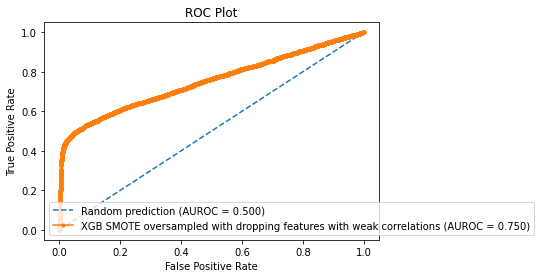

In [215]:
# Plot the ROC curve

# random prediction as baseline in the ROC plot
r_probs = [0 for _ in range(len(y_test_nan_dropped_sc))]
r_auc = roc_auc_score(y_test_nan_dropped_sc, r_probs)
r_fpr,r_tpr,_= roc_curve(y_test_nan_dropped_sc, r_probs)

plt.plot(r_fpr, r_tpr, linestyle='--', label='Random prediction (AUROC = %0.3f)' % r_auc)
plt.plot(xgb_smote_sc_tuned_fpr, xgb_smote_sc_tuned_tpr, marker='.', label='XGB SMOTE oversampled with dropping features with weak correlations (AUROC = %0.3f)'%xgb_smote_sc_tuned_auc)

# Title
plt.title('ROC Plot')
# Axis label
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show legend
plt.legend()
# Show plot
plt.show()

In [217]:
# Using joblib (as a file)
from joblib import dump, load
dump(xgb_smote_sc_tuned, 'bank_cust_churn_pred.joblib') 

['bank_cust_churn_pred.joblib']

In [219]:
# Save predicted values as a csv file
pred_df = pd.DataFrame(y_pred_smote_sc_tuned,columns=['Prediction'])
pred_df.to_csv(f"Bank_Churn_Predicted_Output.csv")